In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.5.1+cu124 0.20.1+cu124


In [2]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

100%|██████████| 169M/169M [00:03<00:00, 43.7MB/s]


Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch
Running on cuda


In [3]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 84. 
Onehot label is 84.


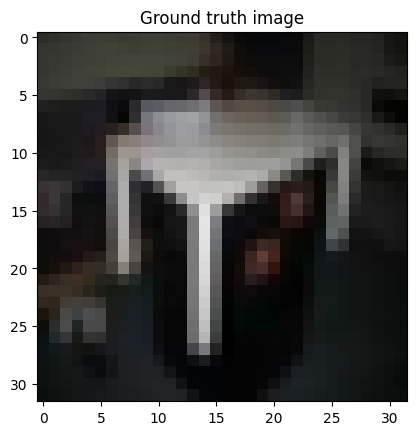

In [4]:
######### honest partipant #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 64.


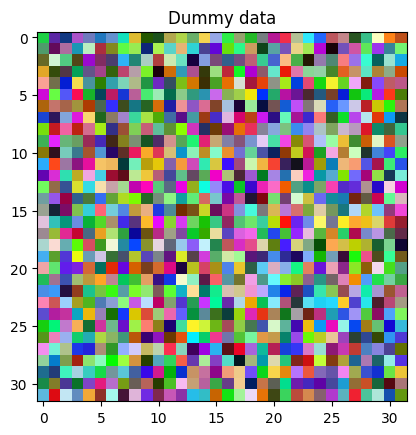

In [5]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [10]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(500):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        dummy_data.grad
        return grad_diff

    # optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 313.7788
10 313.7788
20 313.7788
30 313.7788
40 313.7788
50 313.7788
60 313.7788
70 313.7788
80 313.7788
90 313.7788
100 313.7788
110 313.7788
120 313.7788
130 313.7788
140 313.7788
150 313.7788
160 313.7788
170 313.7788
180 313.7788
190 313.7788
200 313.7788
210 313.7788
220 313.7788
230 313.7788
240 313.7788
250 313.7788
260 313.7788
270 313.7788
280 313.7788
290 313.7788
300 313.7788
310 313.7788
320 313.7788
330 313.7788
340 313.7788
350 313.7788
360 313.7788
370 313.7788
380 313.7788
390 313.7788
400 313.7788
410 313.7788
420 313.7788
430 313.7788
440 313.7788
450 313.7788
460 313.7788
470 313.7788
480 313.7788
490 313.7788


Dummy label is 84.


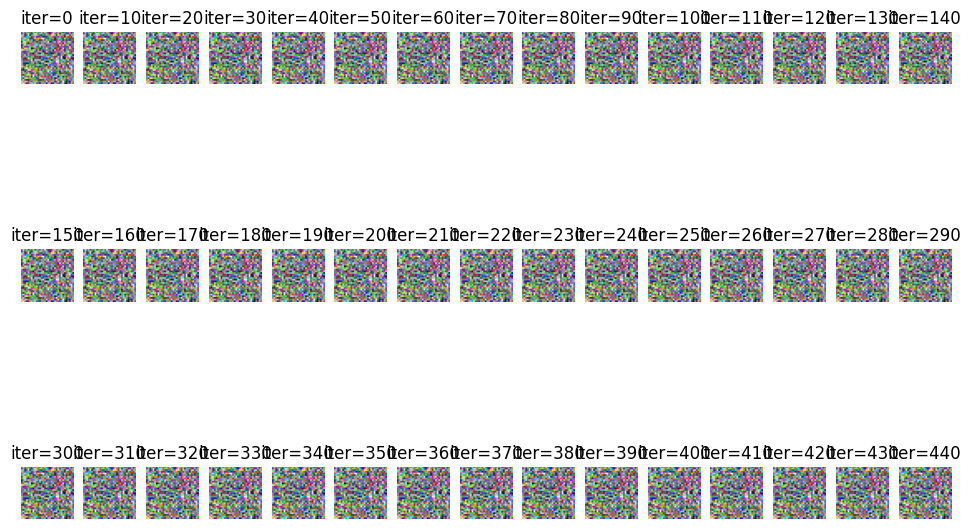

In [13]:
plt.figure(figsize=(12, 8))
for i in range(45):
  plt.subplot(3, 15, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())